In [236]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch
from torch.fft import fft, ifft
from typing import Any
from torchdiffeq import odeint

# Local import
from include.neural_net import NeuralNet

# Uniform plot styles
from matplotlib import rcParams
from plot_style import colors, style

fs = 9
style.update(**{"font.family": "Helvetica", "font.size": fs, "axes.titlesize": fs, "axes.labelsize": fs, "xtick.labelsize": fs, "ytick.labelsize": fs, "legend.fontsize": fs})
rcParams.update(**style)

_textwidth = 6.5
%matplotlib notebook
%matplotlib inline

In [2]:
# Hyperbolic secant function
def sech(x) -> Any:
    return 1 / torch.cosh(x)

In [3]:
class CNLS_Solver:
    def __init__(self, *, t: torch.Tensor, z: torch.Tensor, parameters: dict, **__):
        """Solver class for the coupled non-linear Schrödinger equations.

        :param t: time array
        :param z: space array
        :param parameters: dictionary of the cavity properties, containing:
            - D: chromatic dispersion; normal (D < 0) or anomalous (D > 0)
            - K: the birefringence of the optical fiber
            - E0: cavity saturation energy
            - Omega: bandwidth of the gain media (denoted by tau in original code) #TODO is this right?
            - g0: gain strength (pumping)
            - Gamma: distributed loss of the fiber laser cavity
            - A: non-linear coupling parameter, A + B = 1
            - B: non-linear coupling parameter of the fiber, A + B = 1.
        """

        # Time array
        self.t = t
        self.dt = t[1] - t[0]

        # Space array
        self.z = z
        self.dz = z[1] - z[0]

        # Frequency array, both in the natural order and sorted
        self.k = 2 * torch.pi / (t[-1] - t[0]) * torch.fft.fftfreq(len(t), 1/self.dt)
        self.k_sorted = torch.fft.fftshift(self.k)

        # Cavity parameters
        self.parameters = parameters

    def energy(self, state: torch.Tensor) -> torch.Tensor:
        """Calculate the energy of the beam. The energy is given by

        .. math::
            \int u^2 + v^2 dt

        """
        u, v = state

        return torch.trapezoid(y=torch.conj(u) * u + torch.conj(v) * v, x=self.t).real

    def kurtosis(self, state: torch.Tensor) -> torch.Tensor:
        """ Calculate the kurtosis of a state, given by the sum of the kurtoses of each individual component.
        The kurtosis of a signal is given by the fourth moment about the mean divided by the square of the variance:

        .. math::
            E [ (u-\bar{u})^4 ] / E [ (u-\bar{u})^2 ] ^2

        """
        u, v = state
        I_k = torch.fft.fftshift(fft(u)).abs()**2 + torch.fft.fftshift(fft(v)).abs()**2
        I_k = I_k / I_k.sum()
        M2 = torch.sum(self.k_sorted**2 * I_k)
        M4 = torch.sum(self.k_sorted**4 * I_k)
        return M4 / (M2**2 + 1e-12)
        #return _kurtosis(u) + _kurtosis(v)

    def set_parameter(self, params: dict) -> None:
        """Update the dictionary of parameters"""
        self.parameters.update(params)

    def get_parameter(self, param: str) -> float:
        """Get the current value of a parameter"""
        return self.parameters[param]

    def solve(self, initial_conditions) -> np.ndarray:
        """Solve the coupled non-linear Schrödinger equations. The initial condition is given in real space,
        transformed into Fourier space in the time dimension, and then solved using a RK45 solver.

        :param initial_conditions: the initial condition of the solver, given in real space
        :return (u, v) at z = Z, i.e. at the end of the optical fiber, in real space
        """

        def _rhs_single(_x, _x_f, _y, _y_f, _E, _sign):
            """Helper function for the _cnls_rhs"""

            return (
                - torch.tensor(1j) * 0.5 * self.parameters["D"] * (self.k**2) * _x_f
                + _sign * torch.tensor(1j) * self.parameters["K"] * _x_f
                + torch.tensor(1j) * fft(
                    (torch.conj(_x) * _x + self.parameters["A"] * torch.conj(_y) * _y)
                    * _x
                    + self.parameters["B"] * (_y**2) * torch.conj(_x)
                )
                + 2 * self.parameters["g0"] / (1 + _E / self.parameters["E0"])
                * (1 - self.parameters["Omega"] * (self.k**2)) * _x_f
                - self.parameters["Gamma"] * _x_f
            )

        def _cnls_rhs(_z, _state):
            """Right-hand side of the CNLS. This function is passed to the solver. The state must be passed as a
            flattened array."""

            # u and v in real space
            _u, _v = _state[:int(len(_state) / 2)], _state[int(len(_state) / 2):]

            # u and v in Fourier space
            _u_f, _v_f = fft(_u), fft(_v)

            # Calculate the energy
            E = self.energy(torch.stack([_u, _v]))

            res = torch.stack(
                [
                    _rhs_single(_u, _u_f, _v, _v_f, E, -1),
                    _rhs_single(_v, _v_f, _u, _u_f, E, 1),
                ]
            )
            res = ifft(res, dim=1).flatten()

            return res

        # Use the torch.diffeq odeint solver with the Dopri5Solver (default)
        _solution = odeint(
            _cnls_rhs,
            t=self.z,
            y0=initial_conditions.flatten(),
            method='dopri5'
        )

        # Return the state of the beam after one round trip (final z-value)
        return _solution[-1, :].reshape(2, -1)

In [4]:
# ----------------------------------------------------------------------------------------------------------------------
# Laser cavity class
# ----------------------------------------------------------------------------------------------------------------------
class Laser_cavity:
    """The laser cavity class. The waveplate and polarizer matrices are class properties. The state of the laser is
    given by the current state of (u, v). The laser class contains member functions that allow for setting the waveplate
    angles, performing a single roundtrip and solving the CNLS, and resetting the laser.
    It can also calculate the energy of the beam at its current state."""

    # Quarter waveplate
    W4 = torch.tensor([[torch.exp(-torch.tensor(1j) * torch.pi / 4), 0], [0, torch.exp(torch.tensor(1j) * torch.pi / 4)]])
    # Half waveplate
    W2 = torch.tensor([[-torch.tensor(1j), 0], [0, torch.tensor(1j)]])
    # Polarizer
    WP = torch.tensor([[1, 0], [0, 0]], dtype=torch.cfloat)

    # Stack the waveplates and polarizers into an array
    waveplates_and_polarizers = [W4, W4, W2, WP]

    def __init__(
        self,
        *,
        t: torch.Tensor,
        z: torch.Tensor,
        parameters: dict,
        alpha: torch.Tensor,
        initial_condition: torch.Tensor = None,
        **__
    ):
        """Initialises an instance of the laser.

        :param t: time array
        :param z: space array
        :param parameters: dictionary of the cavity properties, containing:
            - D: chromatic dispersion; normal (D < 0) or anomalous (D > 0)
            - K: the birefringence of the optical fiber
            - E0: cavity saturation energy
            - Omega: bandwidth of the gain media (denoted by tau in original code) #TODO is this right?
            - g0: gain strength (pumping)
            - Gamma: distributed loss of the fiber laser cavity
            - A: non-linear coupling parameter, A + B = 1
            - B: non-linear coupling parameter of the fiber, A + B = 1.
        :param alpha: initial angles of the waveplates
        :param initial_condition: (optional) an initial condition for (u, v), given in real space

        """

        # Initialise the numerical solver
        self.solver = CNLS_Solver(t=t, z=z, parameters=parameters)

        # Angles of the polarizers
        self._alpha = alpha

        # Transformation matrix as a function of alpha
        self._transformation_matrix = self.calculate_transformation_matrix()

        # Store the initial state of the laser, which can be used for resetting
        self._init_state = initial_condition
        self._init_alpha = alpha

        # Current state of u and v
        self.state = initial_condition

        # Current energy
        self.energy = None

        # Current kurtosis
        self.kurtosis = None

        # Current time
        self._t = 0

    def calculate_transformation_matrix(self, alpha: torch.Tensor = None) -> torch.Tensor:
        """Gets the current state of the laser cavity"""

        alpha = self._alpha if alpha is None else alpha

        # Calculate the rotation matrices from the current angle
        rotation_matrices = [
            torch.stack(
                [torch.cos(_alpha), -torch.sin(_alpha), torch.sin(_alpha), torch.cos(_alpha)]
            ).reshape(2, -1).cfloat()
            for _alpha in alpha
        ]

        # Return the transformation matrix: J_1 * J_p * J_2 * J_3
        J = [
            rotation_matrices[i]
            @ self.waveplates_and_polarizers[i]
            @ rotation_matrices[i].T
            for i in range(4)
        ]
        return J[0] @ J[-1] @ J[1] @ J[2]

    def transformation_matrix(self):
        """ Gets the transformation matrix """
        return self._transformation_matrix

    def set_transformation_matrix(self, transformation_matrix: torch.Tensor) -> None:
        """ Sets the transformation matrix"""
        self._transformation_matrix = transformation_matrix

    def apply_transformation(self, state) -> torch.Tensor:
        """Applies the transformation of the waveplates to a given state"""
        return self._transformation_matrix @ state

    def set_alpha(self, alpha: torch.Tensor) -> None:
        """Setter function for alpha. When changing the angles of the waveplates and polarizers, the
        transformation matrix is automatically adjusted."""
        self._alpha = alpha
        self._transformation_matrix = self.calculate_transformation_matrix(alpha)

    def set_state(self, state: torch.Tensor, *, set_init: bool = False) -> None:
        """Setter function for the current state of (u, v). If specified, also sets this state as the initial
        condition"""
        self.state = state
        if set_init:
            self._init_state = self.state

    def set_energy(self):
        """Calculates and sets the energy of the current state"""
        self.energy = self.solver.energy(self.state)

    def alpha(self):
        """ Returns the current angles of the waveplates """
        return self._alpha

    def reset(self) -> None:
        """Resets the laser to its initial state"""
        self._alpha = self._init_alpha
        self.state = self._init_state
        self._t = 0

    def clear_gradients(self) -> None:
        """ Clears the gradients of the parameters"""
        self._alpha = self._alpha.detach()
        self.state = self.state.detach()

    def round_trip(self, *, update_self: bool = True) -> tuple:
        """Performs a round trip of the beam around the laser cavity, using the solver, and applies the
         waveplate transformation. The transformation is then applied, and the state after
         the transformation returned, as well the updated energy. The state of the cavity is then updated to
        in preparation for a new round trip (optional).

        :param update_self: (optional) whether to update the state of the laser. True by default, but can be turned off
            for testing.
        :returns: tuple of the new state behind the waveplates and the new energy
        """

        # Solve the PDE with the current state as the initial condition
        new_state = self.solver.solve(self.state)

        # Calculate the energy of the new state
        new_energy = self.solver.energy(new_state)

        # Apply the waveplate transformation to the current state
        new_state = self.apply_transformation(new_state)

        if update_self:

            # Apply the transformation matrix
            self.state = new_state

            # Update the energy
            self.energy = new_energy

            # Update the kurtosis
            self.kurtosis = self.solver.kurtosis(new_state)

            self._t += 1

        return new_state, new_energy

In [6]:
class Laser_NN:
    def __init__(
        self,
        *,
        neural_net: NeuralNet,
        laser: Laser_cavity,
        **__,
    ):
        """Initialize the model instance with a previously constructed RNG and
        HDF5 group to write the output data to.

        :param rng (np.random.Generator): The shared RNG
        :param h5group (h5.Group): The output file group to write data to
        :param neural_net: The neural network
        :param laser: the uninitialised laser
        :param batch_size (int): update the neural network parameters after a given number of round trips
        :param write_start: iteration at which to start writing
        """
        self.neural_net = neural_net
        self.neural_net.optimizer.zero_grad()
        self.laser = laser

        # Objective to be maximised
        self.objective = torch.tensor(0.0)


    def initialise_laser(self, initial_condition: torch.Tensor, n_round_trips: int = 100) -> None:
        """ Initialises the laser to a given initial condition"""

        # Set the initial state of the laser, given in real space
        self.laser.set_state(initial_condition, set_init=True)

        # Calculate the initial energy
        self.laser.set_energy()

        # Perform n round trips
        for _ in (pbar := tqdm.trange(n_round_trips)):
            self.laser.round_trip()
            pbar.set_description(f"Initialising: J = {(self.laser.energy / self.laser.kurtosis):>.4g}")

    def set_parameters_from_NN(self, *, requires_grad: bool = True) -> None:
        """ Set the parameters of model to the output of the neural network. By default, these are tracked through the
        numerical solver and gradients can then be used to optimise the neural network."""

        # Make a prediction. The neural network must output values in [-1, 1] (-90 to +90)
        #spec = torch.cat([torch.abs(fft(model.laser.state[0]))**2, torch.abs(fft(model.laser.state[1]))**2])
        prediction = torch.pi * self.neural_net(
           torch.ones(self.neural_net.input_dim) #spec - spec.mean()
        ).flatten()

        # Set the transformation matrix of the laser using the current prediction
        self.laser.set_alpha(prediction)

    def objective_function(self) -> torch.Tensor:
        """" Calculate the objective function of the laser, which is the energy divided by the fourth moment
         of the Fourier spectrum """

        return self.laser.solver.energy(self.laser.state) / self.laser.solver.kurtosis(self.laser.state)

    def perform_step(self):
        """ Performs a single gradient descent step."""
        loss = -self.objective_function()
        loss.backward()
        self.neural_net.optimizer.step()
        self.neural_net.optimizer.zero_grad()

        self.objective = -loss.detach().clone()
        self.laser.clear_gradients()

## Initialise the laser

In [197]:
# Initial angles
alpha_0 = torch.tensor([torch.pi/6, torch.pi/6, torch.pi/5, torch.pi/4]).float()

In [7]:
laser = Laser_cavity(
    parameters=dict(D=1, K=0.1, K_std=1e-3, E0=1, Omega=0.1, g0=0.3, Gamma=0.2, A=1/3, B=2/3),
    t=torch.linspace(-25, +25, 256),
    z=torch.tensor([0, 0.5, 1]),
    alpha=alpha_0 # initial angles
)

NN = NeuralNet(
    input_size=2 * len(laser.solver.t),
    output_size=4,
    num_layers=3,
    nodes_per_layer=dict(default=20),
    biases=dict(default=None),
    activation_funcs=dict(default='sigmoid', layer_specific={-1: 'sigmoid'}),
    optimizer='Adam',
    lr=0.001,
)

model = Laser_NN(
    laser=laser,
    neural_net=NN,
)

model.initialise_laser(torch.stack([torch.cosh(model.laser.solver.t) ** (-1), 0.2 * torch.cosh(model.laser.solver.t) ** (-1)]).cfloat(), n_round_trips=1)

Initialising: J = 2.642: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]


## Initialise the laser to a mode-locked state

In [9]:
init_state, init_energy, init_kurtosis = [], [], []

In [45]:
# Initialise
for _ in tqdm.trange(3000):
    model.laser.round_trip()
    init_state.append(model.laser.state)
    init_energy.append(model.laser.energy)
    init_kurtosis.append(model.laser.kurtosis)
steady_init_state = model.laser.state

100%|██████████| 3000/3000 [00:26<00:00, 111.37it/s]


In [544]:
model.laser.set_state(steady_init_state)

In [28]:
from dantro.plot.utils import ColorManager
cm_GrYeOr = ColorManager(
    cmap={'continuous': True, 'from_values': {0: 'black', 0.5: colors['c_darkblue'], 0.95: colors['c_lightblue'], 1: 'white'}},
)

In [137]:
len(init_state) * 1 /3e9

6e-06

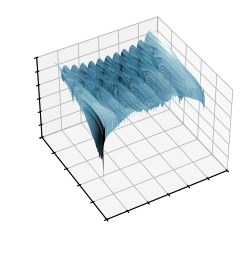

In [235]:
# Plot the beam intensity as it initialises
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), gridspec_kw={'hspace': 0.2, 'wspace': 0.1}, figsize=(_textwidth/3, _textwidth/3))

x, y = np.meshgrid(model.laser.solver.k_sorted, torch.arange(len(init_state[10:])))
ax.plot_surface(x, y, torch.log10(torch.fft.fftshift(fft(torch.stack(init_state)[10:, 0, :]), dim=-1).abs()**2 + torch.fft.fftshift(fft(torch.stack(init_state)[10:, 1, :]), dim=-1).abs()**2 + 1e-12), cmap=cm_GrYeOr.cmap, axlim_clip=True)
#ax.set_xlabel('$k$', labelpad=-10)
#ax.set_ylabel(ylabel='$t$', labelpad=-10)
#ax.set_zlabel(zlabel='$I$', labelpad=-15)
#ax.set_zlabel('$I(k, t)$', )
ax.view_init(elev=40, azim=60+180)
#ax.set_zlim(-1, None)
ax.set_xticks(ax.get_xticks(), [])
ax.set_yticks(ax.get_yticks(), [], ha='right')
ax.set_zticks(ax.get_zticks(), [])
ax.tick_params(axis='y', which='major', pad=-4)
#ax.set(xlabelpad=0)
fig.savefig("/Users/thomasgaskin/Projects/Thesis/Laser_modelocking.png", dpi=500, bbox_inches='tight', transparent=True)

[Text(0.5, 1.0, 'Spectral intensity $I(k)$ (log-scaled)')]

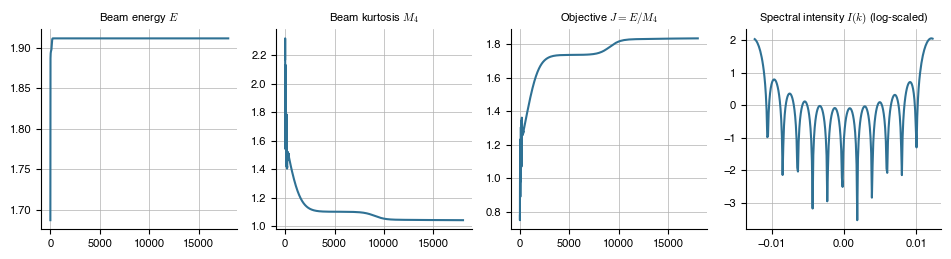

In [162]:
fig, axs = plt.subplots(ncols=4, figsize=(9, 2))
axs[0].plot(init_energy)
axs[0].set(title='Beam energy $E$')
axs[1].plot(init_kurtosis)
axs[1].set(title='Beam kurtosis $M_4$')
axs[2].plot(torch.stack(init_energy)/torch.stack(init_kurtosis))
axs[2].set(title='Objective $J = E / M_4$')
axs[3].plot(model.laser.solver.k_sorted,
            torch.log10(torch.fft.fftshift(fft(torch.stack(init_state)[-1, 0, :])).abs()**2 + torch.fft.fftshift(fft(torch.stack(init_state)[-1, 1, :])).abs()**2 + 1e-12))
axs[3].set(title="Spectral intensity $I(k)$ (log-scaled)")

In [198]:
# Initialise the NN to output the initial angles
spec = torch.ones(model.neural_net.input_dim) #torch.cat([torch.abs(fft(model.laser.state[0]))**2, torch.abs(fft(model.laser.state[1]))**2])
#spec -= spec.mean()
optim = torch.optim.Adam(model.neural_net.parameters(), lr=0.002)
for _ in (pbar := tqdm.trange(1000)):
    pred = torch.pi * model.neural_net(spec)
    loss = torch.nn.functional.mse_loss(pred, alpha_0)
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_description(f"Loss: {loss.detach()}")
print(pred * 180/torch.pi)

Loss: 0.0: 100%|██████████| 1000/1000 [00:00<00:00, 1399.95it/s]                  


tensor([30., 30., 36., 45.], grad_fn=<DivBackward0>)


In [199]:
model.laser.set_state(steady_init_state)
# model.laser.clear_gradients()

In [200]:
# Optimise the angles
state_calib, energy_calib, kurtosis_calib = [], [], []
for i in (pbar := tqdm.trange(100)):

    # Update the angles
    model.set_parameters_from_NN()

    # Perform n round trips after each adjustment to achieve equilibrium
    for _ in range(10):
        model.laser.round_trip()
        state_calib.append(model.laser.state.clone().detach())
        energy_calib.append(model.laser.energy.clone().detach())
        kurtosis_calib.append(model.laser.kurtosis.clone().detach())

    # Adjust the angles
    model.perform_step()

    pbar.set_description(f"J: {model.laser.energy/model.laser.kurtosis:>.4g}, K: {model.laser.solver.parameters['K']:>.4g}, Angles: {', '.join([f'{(a/torch.pi * 180):>.4g}º' for a in model.laser._alpha.numpy().tolist()])}")

J: 1.92, K: -0.2058, Angles: 20.55º, 31.09º, 37.29º, 43.77º: 100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


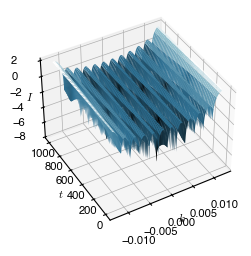

In [168]:
# Plot the beam intensity as it initialises
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), gridspec_kw={'hspace': 0.2, 'wspace': 0.1}, figsize=(_textwidth/3, _textwidth/3))

x, y = np.meshgrid(model.laser.solver.k_sorted, torch.arange(len(state_calib[:])))
ax.plot_surface(x, y, torch.log10(torch.fft.fftshift(fft(torch.stack(state_calib)[:, 0, :]), dim=-1).abs()**2 + torch.fft.fftshift(fft(torch.stack(state_calib)[:, 1, :]), dim=-1).abs()**2 + 1e-12), cmap=cm_GrYeOr.cmap, axlim_clip=True)
ax.set_xlabel('$k$', labelpad=-10)
ax.set_ylabel(ylabel='$t$', labelpad=-10)
ax.set_zlabel(zlabel='$I$', labelpad=-15)
#ax.set_zlabel('$I(k, t)$', )
ax.view_init(elev=40, azim=60+180)
#ax.set_zlim(-1, None)
# ax.set_xticks(ax.get_xticks(), [])
# ax.set_yticks(ax.get_yticks(), ['$0$', '', '', '', '', fr'${len(state_calib) * 1 /3e9:>.1g} s$'], ha='right')
# ax.set_zticks(ax.get_zticks(), [])
ax.tick_params(axis='y', which='major', pad=-4)
#ax.set(xlabelpad=0)
#fig.savefig("/Users/thomasgaskin/Projects/Thesis/Laser_modelocking.png", dpi=500, bbox_inches='tight', transparent=True)

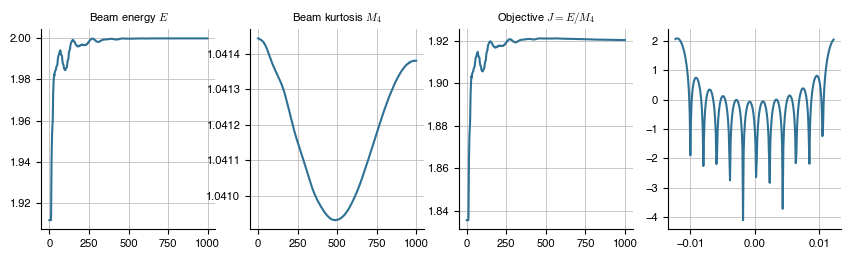

In [169]:
fig, axs = plt.subplots(ncols=4, figsize=(8, 2))
axs[0].plot(energy_calib)
axs[0].set(title='Beam energy $E$')
axs[1].plot(kurtosis_calib)
axs[1].set(title='Beam kurtosis $M_4$')
axs[2].plot(torch.stack(energy_calib)/torch.stack(kurtosis_calib))
axs[2].set(title='Objective $J = E / M_4$')
axs[3].plot(model.laser.solver.k_sorted,
            torch.log10(torch.fft.fftshift(fft(torch.stack(state_calib)[-1, 0, :])).abs()**2 + torch.fft.fftshift(fft(torch.stack(state_calib)[-1, 1, :])).abs()**2 + 1e-12))

In [172]:
#optimised_init_state = model.laser.state.clone()

## Create a birefringence time series

In [170]:
K = [torch.tensor(0.1)]
for _ in range(10000):
    K.append(torch.clip(torch.normal(K[_], torch.tensor(1e-2)), -0.3, +0.3))
K = torch.stack(K)

[None]

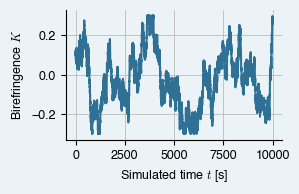

In [237]:
fig, ax = plt.subplots(figsize=(_textwidth/3, _textwidth/5))
ax.plot(K, color=colors['c_darkblue'])
ax.set(ylabel='Birefringence $K$', xlabel='Simulated time $t$ [s]')
fig.set(facecolor='#ECF3F6')
ax.set(facecolor='#ECF3F6')

## Simulate the laser behaviour without controls

In [173]:
# Run the model without the control
objective_no_control = []
for i in (pbar := tqdm.trange(1000)):

    # Vary the birefringence
    if i % 10 == 0:
        model.laser.solver.set_parameter(dict(K=K[i]))

    # Perform n round trips to achieve equilibrium
    for _ in range(10):
        model.laser.round_trip()

    # Write the data
    objective_no_control.append((model.laser.energy/model.laser.kurtosis).detach())
    pbar.set_description(f"E: {model.laser.energy:>.4g}, M_4: {model.laser.kurtosis:>.4g}, J: {model.laser.energy/model.laser.kurtosis:>.4g}, K: {model.laser.solver.parameters['K']:>.4g}")

E: 1.483, M_4: 1.445, J: 1.026, K: -0.2058: 100%|██████████| 1000/1000 [03:06<00:00,  5.36it/s] 


## Add a control

In [201]:
#model.laser.set_state(optimised_init_state)
model.laser.clear_gradients()

In [194]:
objective_with_control = []
angles = []

In [204]:
# Optimise the angles
for i in (pbar := tqdm.trange(1000)):

    if i % 10 == 0:
        model.laser.solver.set_parameter(dict(K=K[i]))

    # Update the angles
    model.set_parameters_from_NN()

    # Perform n round trips to achieve equilibrium
    for _ in range(10):
        model.laser.round_trip()

    # Adjust the angles
    model.perform_step()
    objective_with_control.append((model.laser.energy/model.laser.kurtosis).detach())
    angles.append(model.laser._alpha.detach())
    pbar.set_description(f"J: {model.laser.energy/model.laser.kurtosis:>.4g}, K: {model.laser.solver.parameters['K']:>.4g}, Angles: {', '.join([f'{(a/torch.pi * 180):>.4g}º' for a in model.laser._alpha.numpy().tolist()])}")

J: 1.917, K: -0.1375, Angles: 10.74º, 16.37º, 32.61º, 46.1º: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


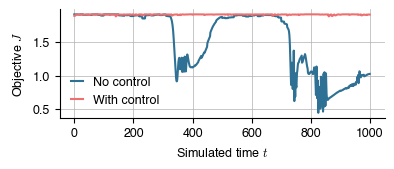

In [238]:
fig, ax = plt.subplots(figsize=(_textwidth/2, _textwidth/6))
ax.plot(objective_no_control, label='No control')
ax.plot(objective_with_control, label='With control')
ax.set(ylabel='Objective $J$', xlabel='Simulated time $t$')
ax.legend(framealpha=0, handlelength=1)
fig.savefig("/Users/thomasgaskin/Projects/Thesis/Laser_objective.pdf", bbox_inches='tight', transparent=True)

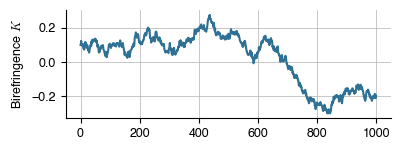

In [239]:
fig, ax = plt.subplots(figsize=(_textwidth/2, _textwidth/6))
ax.plot(K[:len(objective_no_control)])
ax.set(ylabel='Birefringence $K$')
fig.savefig("/Users/thomasgaskin/Projects/Thesis/Laser_birefringence.pdf", bbox_inches='tight', transparent=True)

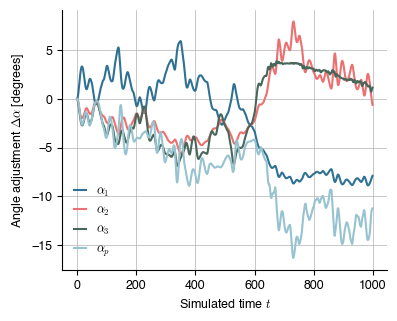

In [242]:
fig, ax = plt.subplots(figsize=(_textwidth/2, 0.4*_textwidth))
ax.plot((torch.stack(angles)-torch.stack(angles)[0]) * 180 / torch.pi, label=[r'$\alpha_1$', r'$\alpha_2$', r'$\alpha_3$', r'$\alpha_p$'])
ax.set(ylabel=r'Angle adjustment $\Delta \alpha$ [degrees]', xlabel='Simulated time $t$')
ax.legend(handlelength=1, framealpha=0)
fig.savefig("/Users/thomasgaskin/Projects/Thesis/Laser_control_angles.pdf", bbox_inches='tight', transparent=True)